# Evaluate Alpha Factor

In [22]:
#!pip install empyrical
#!pip install ruptures
#!pip install pandas_market_calendars
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, sign
from pandas import concat
import empyrical as ep
import datetime
from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel

In [2]:
# read data in
test_data = pd.read_csv('test_data.csv',)
pnl_new=pd.read_csv('pnl_details_new_signal.csv')
pnl_base=pd.read_csv('pnl_details_base_model.csv')
pnl_combined=pd.read_csv('pnl_details_combined.csv')

test_data['date']=pd.to_datetime(test_data['date'], format="%m/%d/%Y")
pnl_new['date']=pd.to_datetime(pnl_new['date'], format="%m/%d/%Y")
pnl_base['date']=pd.to_datetime(pnl_base['date'], format="%m/%d/%Y")
pnl_combined['date']=pd.to_datetime(pnl_combined['date'], format="%m/%d/%Y")

date=test_data['date']
test_data=test_data.set_index('date')

## 1. General overview

We first have a general overview of the performances using the new signal, the base model, and the combined model. It shows the mean, standard deviation, and some quatiles of the returns ($PnL/LMV). 

In [3]:
test_data.describe()

,new signal,base model,combined
count,2816.000000,2816.000000,2816.000000
mean,0.000487,0.002510,0.002511
std,0.006486,0.006782,0.006749
min,-0.040939,-0.032378,-0.031556
25%,-0.003245,-0.001125,-0.001169
50%,0.000369,0.002723,0.002749
75%,0.003999,0.006596,0.006541
max,0.051640,0.036013,0.036507


We can also visualize the daily return and their distribution density to have an intuitive understanding of their performances.

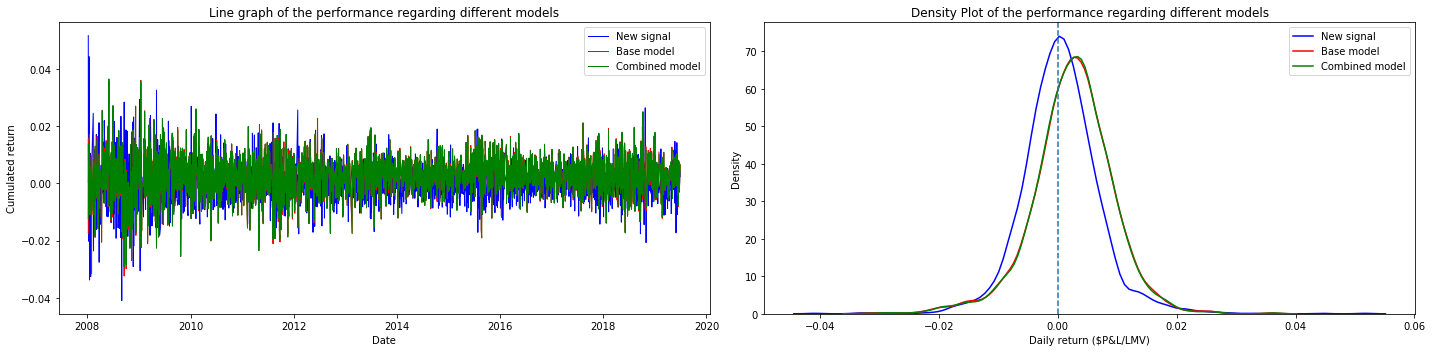

In [20]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(date,test_data['new signal'], color='b',label='New signal',linewidth=1)
axs[0].plot(date,test_data['base model'], color='r',label='Base model',linewidth=1)
axs[0].plot(date,test_data['combined'], color='g',label='Combined model',linewidth=1)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulated return')
axs[0].title.set_text('Line graph of the performance regarding different models')
sns.distplot(test_data['new signal'], hist=False, color='b',label='New signal', ax=axs[1])
sns.distplot(test_data['base model'], hist=False,color='r',label='Base model', ax=axs[1])
sns.distplot(test_data['combined'], hist=False, color='g',label='Combined model', ax=axs[1])
plt.axvline(0,linestyle='--')
plt.title('Density Plot of the performance regarding different models')
plt.xlabel('Daily return ($P&L/LMV)')
plt.ylabel('Density')
axs[0].legend()
fig.tight_layout()
plt.show()

Based on the plots, we cannot draw many conclusions directly about the New signal. By comparing the combined model with the base model on the graph, it seems that the new signal does not bring much more improvement to the model. Further research will be done regarding our guesses.



### Check for Stationary

Before we do further analysis, we first need to check whether the three time series are stationary. A time series is stationaty when the statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. If the stationary assumption is violated, the conclusion we made for the whole time series may not explain some specific intervals in it. 

From the line graph, all the three time series look stationary. We will do Augmented Dickey-Fuller tests to support the statement. The null hypothesis suggests that the time series has a unit root and thus has some time dependent structure. Rejecting the null hypothesis implies the time series is stationary.

In [5]:
#check if stationary
from statsmodels.tsa.stattools import adfuller
result_new = adfuller(test_data['new signal'].values)
result_base = adfuller(test_data['base model'].values)
result_combined = adfuller(test_data['combined'].values)
print('New signal:     ADF Statistic=%.3f' % result_new[0]+', '+'p-value=%.3f' % result_new[1])
print('Base model:     ADF Statistic=%.3f' % result_base[0]+', '+'p-value=%.3f' % result_base[1])
print('Combined model: ADF Statistic=%.3f' % result_combined[0]+', '+'p-value=%.3f' % result_combined[1])

New signal:     ADF Statistic=-14.242, p-value=0.000
Base model:     ADF Statistic=-7.350, p-value=0.000
Combined model: ADF Statistic=-7.308, p-value=0.000


All the p-values are close to zero, which gives us enough evidence to conclude that all three time series do not have a unit root and are stationary. 

### Check for Autocorrelation

We then check for the autocorrelation and partial autocorrelation for the return time series. 
If the daily return of a strategy has high autocorrelation, negative return might happen in consecutive days, which lead to high risk. Partial autocorrelation also contains relations between an observation and an observation at a prior time step. In the following figures, we plot the autocorrelation function(ACF) and partial autocorrelation function(PACF) regarding the daily return of the three strategy.

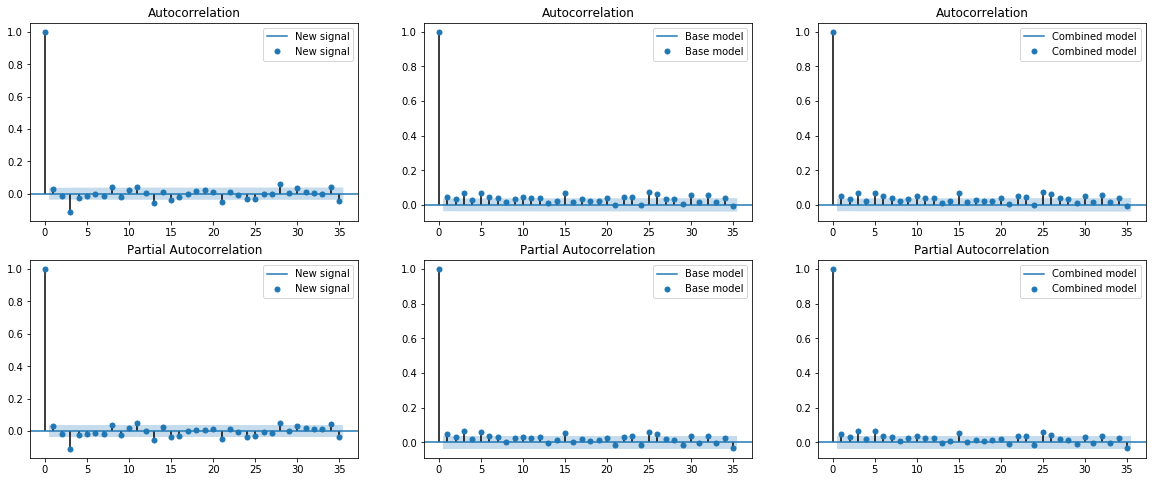

In [6]:
#acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(2,3,figsize=(20,8))
plot_acf(test_data['new signal'],ax=axs[0,0],label='New signal')
plot_pacf(test_data['new signal'],ax=axs[1,0],label='New signal')
plot_acf(test_data['base model'],ax=axs[0,1],label='Base model')
plot_pacf(test_data['base model'],ax=axs[1,1],label='Base model')
plot_acf(test_data['combined'],ax=axs[0,2],label='Combined model')
plot_pacf(test_data['combined'],ax=axs[1,2],label='Combined model')
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,1].legend()
axs[1,0].legend()
axs[1,2].legend()
plt.show()

Based on the plots, nearly no autocorrelation is between the observations. Thus, it might be safe to assume that the returns are independent between days. 

## 2. Whether the new signal is qualified. 

From the pnl_details, we can recover the daily returns of the stocks we are dealing with. The daily return is calculate by the equation:

$$
Return=\frac{pnl_{usd}}{mv_{usd}-trade_{usd}-pnl_{usd}}
$$

With the daily return of the stocks, we can plot the bar chart of Mean Period-Wise Return by Quantile to get a preliminary understanding of how the factor value tracks with returns. A good alpha factor should has high mean return for large quantile and small mean return for low quantile.

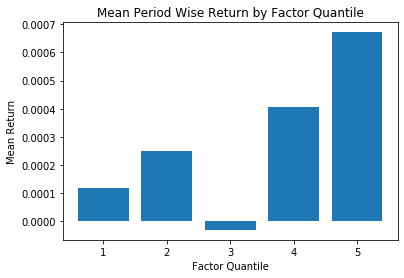

In [7]:
pnl_new['pre_mv_now_value']=pnl_new['mv_usd']-pnl_new['trade_usd']
pnl_new['abs_pre_mv_now_value']=abs(pnl_new['pre_mv_now_value'])
pnl_new['pre_mv']=pnl_new['mv_usd']-pnl_new['trade_usd']-pnl_new['pnl_usd']
pnl_new['return']=(pnl_new['pnl_usd'])/(pnl_new['pre_mv'])
pnl_new=pnl_new.fillna(0)
part_line=[]
for temp_i in range(5):
    part_line.append(np.quantile(pnl_new['pre_mv'], (temp_i+1)/5))
pnl_new['factor_quantile']=1
for temp_i in range(4):
    pnl_new['factor_quantile']+=pnl_new['pre_mv']>part_line[temp_i]
return_quant=pnl_new.groupby(['factor_quantile']).mean()['return']
plt.bar(range(1,len(return_quant)+1), return_quant)
plt.title('Mean Period Wise Return by Factor Quantile')
plt.xlabel('Factor Quantile')
plt.ylabel('Mean Return')
plt.show()

The abnormal for the 3rd factor quantile is because there is very little position here, and thus the return cannot represent the true situation. Other than that, we see that the new signal seems to be viable to capture relatively better stocks. In the following, we will do a hypothesis test to see whether the strategy based on the new signal is profitable on average. 

### One sample test for the return regarding the new signal

Let $\mu_{new}$ be the mean of the performance using the new signal. We consider the hypothesis
$H_0$: $\mu_{new}$=0  vs  $H_1$:$\mu_{new}>0$, and use one-sample t-test to check the significance. 

In [8]:
# Student's t-test for independent samples
data1 = test_data['new signal']
stat, p =  ttest_1samp(data1, 0)
p_oneside=p/2
print('T-Statistic=%.3f, P-Value=%.3f' % (stat, p_oneside))

T-Statistic=3.987, P-Value=0.000


The p-value is very close to zero, thus based on the t-test, we say that the stratigy with the new signal brings positive return on average. We should keep in mind that such positive return might be caused by the market overall movement. We need the following analysis to see if that is the case.

### Whether the performance of the new signal is irrelavent to the market movement.

The first thing to do is to measure the market movement. There are some popular criteria like S&P 500, Dow Jones, and Nasdaq. Based on the given dataset, we use the change of the Gross market value before adjustment. Details are explained as follows: 

To keep a constant target GMV of $200MM, the system needs to trade stocks even when the value of alpha factor does not change. The current market value(mv_usd) minus the trade amount(trade_usd) is how much the stocks we own yesterday that values today. If it's absolute value goes up, it means the stock is rising. By taking the summation, we can get the overall movement of the stocks in the portfolio. Therefore, the feature "market_mov" is constructed as follows: 

In [9]:
pnl_new['pre_mv_now_value']=pnl_new['mv_usd']-pnl_new['trade_usd']
pnl_new['abs_pre_mv_now_value']=abs(pnl_new['pre_mv_now_value'])
pnl_new_group=pnl_new.groupby(['date']).sum().sort_values(by='date')
pnl_new_group['market_mov']=pnl_new_group['abs_pre_mv_now_value'].diff()
pnl_new_group['market_mov'].describe()

count    2.816000e+03
mean     7.082763e+04
std      5.197222e+06
min     -1.948894e+07
25%     -1.971614e+06
50%     -1.410111e+05
75%      1.868822e+06
max      2.007904e+08
Name: market_mov, dtype: float64

Let "market_mov"/2e+8 be the return of the broader market. We now can calculate the market beta of the new signal to see the market influence to the factor.  The market beta measures the exposure of a stategy to the broader market. A large absolute value of market beta means easily influence by the market.

In [10]:
print ("The market beta regarding the new signal is",ep.beta(test_data['new signal'],pnl_new_group['market_mov']/2e+8))

The market beta regarding the new signal is 0.01505222920654091


We can see that the market beta is small. This means that the new signal has very little exposure to the broader market, it is market neutral.
We can also construct a t-test to see whether the performance of the new signal differs when the market is up or down. 

In [11]:
#a two-sample t-test to test the difference in the mean
data1 = test_data['new signal'][(pnl_new_group['market_mov']>0)[1:]]#the performance of new signal when market goes up
data2 = test_data['new signal'][(pnl_new_group['market_mov']<0)[1:]]#the performance of new signal when market goes down
stat, p =  ttest_ind(data1, data2)
print('T-Statistic=%.3f, P-Value=%.3f' % (stat, p))

T-Statistic=-0.944, P-Value=0.345


Since the p-value is 0.345, we don't have enough evidence to say that the performance of the new signal is influenced by the market movement. 

## 3. Compare the combined model with the other two.

We just consider the new signal on its own. Now we combine the new signal with our base model and see whether it can make an improvement. It is possible that the new signal does not bring better performance as the information from the new signal is already captured by the base model. 

### Two sample test between the base model and the combined model

We first consider whether the mean of the performance is different.
$H_0: \mu_{combined}=\mu_{base} \ vs\  H_1: \mu_{combined}\ne\mu_{base}$

In [12]:
data1 = test_data['base model']
data2 = test_data['combined']

stat, p =  ttest_rel(data1, data2)
print('T-Statistic=%.3f, P-Value=%.3f' % (stat, p))

T-Statistic=-0.098, P-Value=0.922


Based on the result, we do not have enough evidence to conclude that the combine model is different with the base model in the performance mean.

We then consider the variance of the performance. With same mean return, a lower variance leads to less risk.
$H_0: \sigma^2_{combined}=\sigma^2_{base} \ vs\  H_1: \sigma^2_{combined}\ne\sigma^2_{base}$

We use Levene's test for the variace difference. 

In [13]:
from scipy.stats import levene
data1 = test_data['base model']
data2 = test_data['combined']
stat, p =  levene(data1, data2)
print('Test-Statistic=%.3f, P-Value=%.3f' % (stat, p))

Test-Statistic=0.035, P-Value=0.851


Based on the result, the variances of performance of the base model and the combine model are also similar. 

From the two tests, we did not receive enough comfort to include the new signal into our model. In the following, we will compare other characteristic of the performance between the base model and the combined model.

### Risk-Adjusted Return

The risk-adjusted return is an essential metric of any strategy. Risk-adjusted returns allow us to judge returns streams that have different individual volatilities by providing an avenue for meaningful comparison. One of the most popular risk-adjusted returns is the Sharpe ratio, which is defined as:

$$
\text{Sharpe Ratio}=\frac{E[R_p-R_f]}{\sigma_p},
$$
where
$R_p$= return of portfolio, 
$R_f$= risk-free rate, 
$\sigma_p$= standard deviation of the portfolio's excess return.
Here, we assume that the risk-free rate is zero.

By comparing the Sharpe ratio of the three strategy, we can see whether the new signal brings more profit taking the same risk.

In [14]:
print ("The Sharpe Ratio regarding the new signal is:", ep.sharpe_ratio(test_data['new signal']))
print ("The Sharpe Ratio regarding the base model is:", ep.sharpe_ratio(test_data['base model']))
print ("The Sharpe Ratio regarding the combined model is:", ep.sharpe_ratio(test_data['combined']))

The Sharpe Ratio regarding the new signal is: 1.192784709514386
The Sharpe Ratio regarding the base model is: 5.8751314953702884
The Sharpe Ratio regarding the combined model is: 5.906349265863194


The results show that the combined model does have a larger sharpe ratio, but the improvement looks not severe.

### Market Beta

As I mentioned before, the market beta of an algorithm is the exposure of that stategy to the broader market. As before, we use 'market_mov'/2e+8 to indicate the market return, and calculate the market beta for the base model and the combined model.

In [15]:
#calculate market beta
pnl_combined['pre_mv_now_value']=pnl_combined['mv_usd']-pnl_combined['trade_usd']
pnl_combined['abs_pre_mv_now_value']=abs(pnl_combined['pre_mv_now_value'])
pnl_combined_group=pnl_combined.groupby(['date']).sum().sort_values(by='date')
pnl_combined_group['market_mov']=pnl_combined_group['abs_pre_mv_now_value'].diff()
pnl_combined_group['market_mov'].describe()

pnl_base['pre_mv_now_value']=pnl_base['mv_usd']-pnl_base['trade_usd']
pnl_base['abs_pre_mv_now_value']=abs(pnl_base['pre_mv_now_value'])
pnl_base_group=pnl_base.groupby(['date']).sum().sort_values(by='date')
pnl_base_group['market_mov']=pnl_base_group['abs_pre_mv_now_value'].diff()
pnl_base_group['market_mov'].describe()

print ("The market beta regarding the base model is",ep.beta(test_data['base model'],pnl_base_group['market_mov']/2e+8))
print ("The market beta regarding the combined model is",ep.beta(test_data['combined'],pnl_combined_group['market_mov']/2e+8))

The market beta regarding the base model is 0.01027761866967481
The market beta regarding the combined model is 0.01190263404975758


Both models have small market beta. In comparison, the combined model is more related to the market. 

### Top Long and Short Positions

The tables below list the top 5 long and short positions of all time. The goal of each algorithm is to minimize the proportion of the portfolio invested in each stock at any time point. This prevents the movement of any individual stock from having a significant impact on the portfolio as a whole. The bigger the exposure a strategy has to any stock, the greater the risk.

In [16]:
#top 5 long and short
pnl_base_group=pnl_base.groupby(['ticker']).mean()
pnl_base_group['pos_percent']=pnl_base_group['mv_usd']/2e+8
temp_head=pnl_base_group['pos_percent'].sort_values(ascending=False)[:5]
temp_tail=pnl_base_group['pos_percent'].sort_values(ascending=True)[:5]
base_top_pos=concat([temp_head,temp_tail])
print('The top 5 long and short positions for base model: \n',base_top_pos)

The top 5 long and short positions for base model: 
 ticker
12406    0.011537
12695    0.009144
12351    0.008096
12608    0.007369
12842    0.004814
12256   -0.003266
12435   -0.003192
12227   -0.002784
12396   -0.002595
12252   -0.002523
Name: pos_percent, dtype: float64


In [17]:
#top 5 long and short
pnl_combined_group=pnl_combined.groupby(['ticker']).mean()
pnl_combined_group['pos_percent']=pnl_combined_group['mv_usd']/2e+8
temp_head=pnl_combined_group['pos_percent'].sort_values(ascending=False)[:5]
temp_tail=pnl_combined_group['pos_percent'].sort_values(ascending=True)[:5]
combined_top_pos=concat([temp_head,temp_tail])
print('The top 5 long and short positions for combined model: \n',combined_top_pos)

The top 5 long and short positions for combined model: 
 ticker
12406    0.012011
12695    0.009444
12351    0.007810
12608    0.007427
12842    0.005641
12256   -0.003226
12435   -0.003138
12227   -0.002967
12396   -0.002670
12252   -0.002619
Name: pos_percent, dtype: float64


From the output, we see that neither strategies has high concentration in only a few stocks, which provide good ability to avoid the risk.

###  Drawdowns

A drawdown is the 'peak to trough decline' of an investment strategy. Intuitively speaking, it refers to the losses the strategy has experienced from the base amount of capital which it had at the peak. A significant drawdowns implies a high risk of a strategy. We compare the drawdowns among all the portfolio and see whether including the new signal will reduce the risk.

In [18]:
print ("The maxmimum drawdown regarding the new signal is:", ep.max_drawdown(test_data['new signal']))
print ("The maxmimum drawdown regarding the base model is: ", ep.max_drawdown(test_data['base model']))
print ("The maxmimum drawdown regarding the combined model is: ", ep.max_drawdown(test_data['combined']))

The maxmimum drawdown regarding the new signal is: -0.11785043745921243
The maxmimum drawdown regarding the base model is:  -0.3523126494071255
The maxmimum drawdown regarding the combined model is:  -0.3533341054554689


We see that the combined model might need more preparation to overcome risk. It is reasonalble because more parameters will bring more variation. If a new feature does not bring more information, the noise it contain will increase the variance. 

### The amount of trade.

It is assumed that the trading cost is 0. However, in real implimentation, the trading cost exists and a higher amount of trading will lead to more cost. If the combined model will have less trading amount, including the new signal might be helpful. We construct a new feature records the absolute value of the trading amount and calculate the daily summation. We then use a two-sample t-test to see whether the trading amount between base model and combine model are different. 

In [19]:
pnl_base['abs_trade_usd']=abs(pnl_base['trade_usd'])
pnl_base_group=pnl_base.groupby(['date']).sum().sort_values(by='date')
pnl_combined['abs_trade_usd']=abs(pnl_combined['trade_usd'])
pnl_combined_group=pnl_combined.groupby(['date']).sum().sort_values(by='date')

data1 = pnl_base_group['abs_trade_usd']
data2 = pnl_combined_group['abs_trade_usd']

stat, p =  ttest_ind(data1, data2)
print('T-Statistic=%.3f, P-Value=%.3f' % (stat, p))

T-Statistic=1.523, P-Value=0.128


Based on the p-value, there is not enough evidence to say that the traiding amount between base model and combine model are different.

## 4. Conclusion

Based on the discovery so far, the combined model may bring more profit, but the improvement is not obvious. Including the new signal may also bring more variation to the model. In conclusion, if switching the model has no operation cost and the risk is tolerable, it is worth a shot to include the new signal. Otherwise, more analysis should be done to support the new signal. 